In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat, loadmat
import stwave as st
import DNN_Net
from sklearn.model_selection import train_test_split
from model_prep import Model_Prep

Using TensorFlow backend.


In [2]:
def plot_im(data, nx, title, x_label, y_label, file_name=None, save_file=False):
    plt.figure()
    plt.imshow(data.reshape(nx[1], nx[0]))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.colorbar()
    plt.show()
    if save_file:
        plt.savefig(file_name)

In [3]:
model_data = Model_Prep()
#L_div = 5
#kernel = 'Gaussian'
# A = model_data.generate_cov(L_div, kernel,file_name='Cov.mat', save_data=True)
data_cov = loadmat('Cov.mat')
A = data_cov['A']

In [4]:
n_dom = 100
min_bc_l = 5
max_bc_l = 8
nx = [110, 83]
rec_len = 3
sig_obs = .1
# we can generate different training set with different kernel fcn or lenght scales and then stack them together
#X_tr, y_tr = model_data.generate_training_data(n_dom, min_bc_l, max_bc_l, nx, rec_len, A,
#                                               sig_obs, file_name='train_data.mat', save_data=True)
data_tr = loadmat('training_data.mat')
X_tr = data_tr['X_tr']
y_tr = data_tr['y_tr']


In [5]:
assert (X_tr.shape[1] == rec_len**2), "Dimension mismatch, X should have the dimention n_tr*rec_len^2"

In [6]:
#X_test, y_test = model_data.generate_test_data(rec_len, A, nx, sig_obs, save_data=False)
#test_data = loadmat('test_data.mat')
#x_test = test_data['X_test']
#y_test_ref = test_data['y_test']
#X_test_ref = x_test.T

X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=0.1, random_state=101)

np.random.seed(100)
ord_shuffle = np.arange(X_train.shape[0])

X = X_train[ord_shuffle, :]
Y = y_train[ord_shuffle]

In [7]:

network_params = {'X_train': X, 'Y_train': Y, 'n_unit': [13, 13, 13, 1],
                  'n_hidden': 4, 'n_epoch': 2, 'method': 'Ensemble',
                  'Normalize': True, 'optimizer_meth': 'SGD', 'verbose': True}
np.random.seed(101)
network = DNN_Net.DNN_Net(network_params)




Train on 636154 samples, validate on 159039 samples
Epoch 1/2
636154/636154 [==============================] - 7s 12us/step - loss: 0.2017 - mean_squared_error: 0.0062 - val_loss: 0.0927 - val_mean_squared_error: 0.0026
Epoch 2/2
636154/636154 [==============================] - 7s 11us/step - loss: 0.0653 - mean_squared_error: 0.0025 - val_loss: 0.0505 - val_mean_squared_error: 0.0023


In [8]:
data = loadmat('true_depth.mat', squeeze_me=True)
ref_bathy = data['true']
ref_bathy[ref_bathy < 0.01] = 0.01
ref_bathy = ref_bathy.reshape(-1, 1)
obs_vel = model_data.forward_model(ref_bathy, parallel=False)
obs_vel = obs_vel + np.random.randn(110*83, 1)*.5
n_ens = 4
sig_pri = .1


In [9]:
np.random.seed(101)
y_mean, y_std, Post_Cov = network.get_std_mean_ens(model_data.create_sub_samples_test, obs_vel, n_ens, rec_len, A,
                                                     nx, sig_pri, prior_cov='Gaussian', save_data=False)

8748/8748 [==============================] - 0s 4us/step


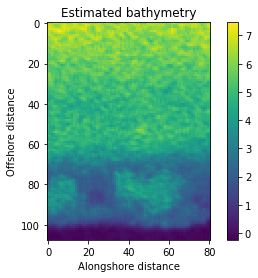

In [10]:
title = 'Estimated bathymetry'
y_label = 'Offshore distance'
x_label = 'Alongshore distance'

plot_im(y_mean, [nx[1]-2, nx[0]-2], title, x_label, y_label)